## Clustering

For our clustering example, we will use the ***ad hoc data set*** as escribed in Super Vised Learning with quantum enhanced feature spacaes, and the **scikit-learn** spectral clustering algorithm.

We will regenerate the dataset with a larger gap between the two classes, and as clustering is an **unsupervised mchine learning task**, we don't need a test sample.

In [6]:
import warnings

# Suppress warning
warnings.filterwarnings("ignore")

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.svm import SVC
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score

from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.datasets import ad_hoc_data

from time import time

seed=12345
algorithm_globals.random_seed = seed  # a "seed" is a starting point for generating random numbers. 

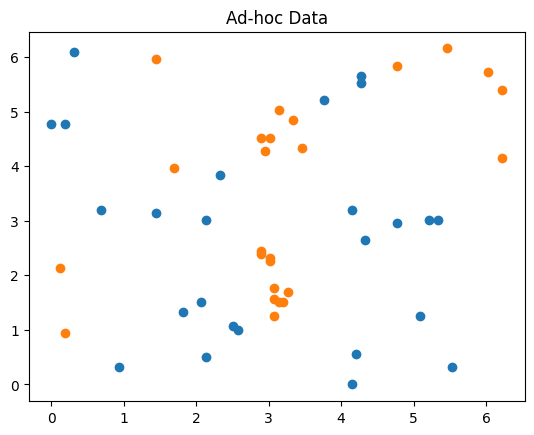

In [2]:
adhoc_dimension = 2
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=25,
    test_size=0,  # as we don't need test data for unsupervised learning
    n=adhoc_dimension,
    gap=0.6,
    plot_data=True,
    one_hot=False,
    include_sample_total=True
)



Text(0.5, 1.0, 'Ad hoc dataset for clustering')

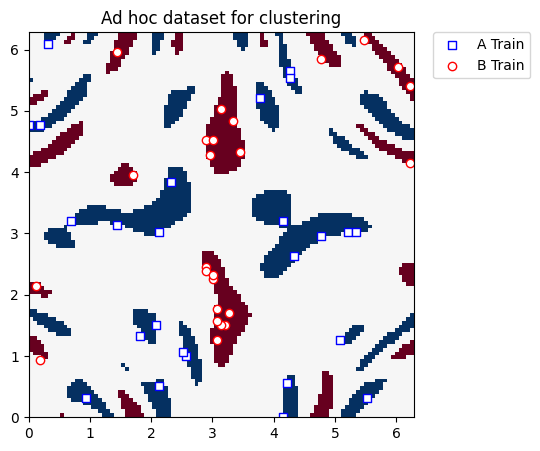

In [3]:
plt.figure(figsize=(5,5))
plt.ylim(0, 2 * np.pi)
plt.xlim(0, 2 * np.pi)
plt.imshow(
    np.asmatrix(adhoc_total).T,
    interpolation="nearest",
    origin="lower",
    cmap="RdBu",
    extent=[0, 2* np.pi, 0, 2 * np.pi],
)

plt.scatter(
    train_features[np.where(train_labels[:] == 0), 0],
    train_features[np.where(train_labels[:] == 0), 1],
    marker='s',
    facecolors='w',
    edgecolors='b',
    label="A Train",
)
    
plt.scatter(
    train_features[np.where(train_labels[:] == 1), 0],
    train_features[np.where(train_labels[:] == 1), 1],
    marker='o',
    facecolors='w',
    edgecolors='r',
    label="B Train",
)


plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.title("Ad hoc dataset for clustering")

We again set up the **QuantumKernelclass** to calculate a kernel matrix
using the **ZZFeatureMap**, and the **BasicAer** **qasm_simulator** using 1024 shots

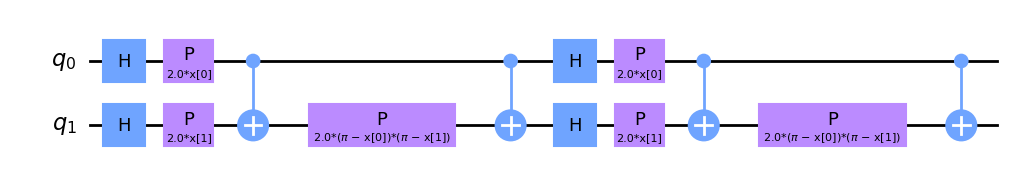

In [4]:
adhoc_feature = ZZFeatureMap(feature_dimension=adhoc_dimension, reps=2, entanglement ="linear")
adhoc_feature.decompose().draw()

#### Now as we have feature map it's time to computer kernel matrix that is similarity matrix

In [7]:
adhoc_backend = QuantumInstance( 
    BasicAer.get_backend("qasm_simulator"), shots=1024, seed_simulator=seed, seed_transpiler=seed
)

adhoc_kernel = QuantumKernel(feature_map=adhoc_feature, quantum_instance=adhoc_backend)

The scikit-learn spectral clustering algorithm allows us to define a custom kernel in two ways:
- By providing the kernel as a callable function or by precomputing the kernel matrix. (We can compute kernel in quantum machine and use this pre compute kernel in classical algortihm)
- We can do either of these using the **QuantumKernel** class in **qiskit** (Qiskit provides a QuantumKernel class that allows you to define and compute quantum kernel directly within qiskit the Qiskit framework.)

The following code precomputes and the plotsthe kernel matrices before providing it to the scikit-learn spectral clustering algorithm, and scoring the labels using normalized mutual information, since we a priori know the class labels.

In [8]:
print(train_features.shape)
print(test_labels.shape)

(50, 2)
(0, 2)


We need to mention the no of class we want to separate for this example we know it is two it can be more for unknown data. Also
we won't know this information prior so we have to select random value and try again

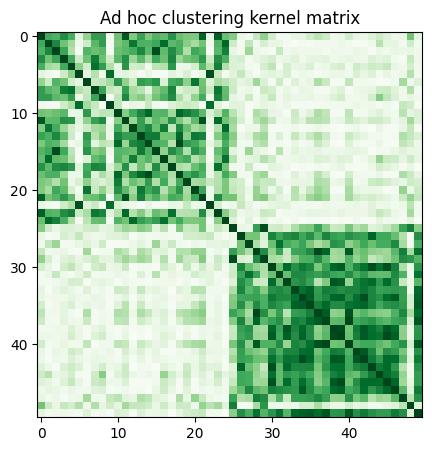

Callable kernel Clustering test score: 0.8782063702756282
Training duration:  0.12630152702331543


In [12]:
adhoc_matrix = adhoc_kernel.evaluate(x_vec=train_features)

plt.figure(figsize=(5,5))
plt.imshow(np.asmatrix(adhoc_matrix), interpolation="nearest", origin="upper", cmap="Greens")
plt.title("Ad hoc clustering kernel matrix")
plt.show()

start_time = time()
adhoc_spectral = SpectralClustering(2, affinity="precomputed")  # as we know it is two class so mentioning 2 class it could be any class for unknown data
cluster_labels= adhoc_spectral.fit_predict(adhoc_matrix)
cluster_score = normalized_mutual_info_score(cluster_labels, train_labels)

end_time = time()
duration = end_time - start_time


print(f"Callable kernel Clustering test score: {cluster_score}")
print("Training duration: ",duration)

scikit-learn has other algorithms that can us a precomputed kernel matrix, here are a few:

- Agglomerative Clustering
- Support Vector Regression (Here y value is continuous)
- Ridge Regression
- Gaussian Process regression
- Principal component analyis
    
***All we need is precomputed kernel matrix which can be created by Quantum Machine***
    